# Sequence Learning - Direct - English
Version 1: In this version we make the model "simple": make the encoder RNN into normal RNN first and try to see the result.  
Version 2: Learning is not very much. Following Dr Coupe's advice we try simpler model structure. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle
from datetime import datetime

In [2]:
from model import PhxLearner, SimplerPhxLearner
from my_dataset import MyTransform, DS_Tools
from phone_dataset import PhoneDataset, collate_fn
from paths import *
from my_utils import *
from recorder import *
from loss import *
from padding import generate_mask_from_lengths_mat, mask_it

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
BATCH_SIZE = 128

INPUT_DIM = 39
OUTPUT_DIM = 13

INTER_DIM_0 = 64
INTER_DIM_1 = 16
INTER_DIM_2 = 3

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400

LOADER_WORKER = 16
# LOADER_WORKER = 0

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
model

SimplerPhxLearner(
  (encoder): RLEncoder(
    (rnn): LSTM(39, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=3, bias=True)
      (relu): Tanh()
    )
  )
  (decoder): RALDecoder(
    (rnn): LSTM(13, 3, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=3, out_features=3, bias=True)
      (w_k): Linear(in_features=3, out_features=3, bias=True)
      (w_v): Linear(in_features=3, out_features=3, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=3, out_features=13, bias=True)
      (relu): Tanh()
    )
  )
)

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [8]:
params

6275

In [9]:
# Just for keeping records of training hists. 
ts = "0908015948"
stop_epoch = "149"
# ts = str(get_timestamp())
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)

save_valhist_name = "val_hist_{}.hst".format(ts)

In [10]:
train_losses = LossRecorder(model_save_dir + save_trainhist_name)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)

text_hist = HistRecorder(model_save_dir + save_txt_name)

In [11]:
# READ = False
READ = True

In [12]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = "PT_{}_{}_full".format(ts, stop_epoch)
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [28]:
mytrans = MyTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT)
ds = PhoneDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)


if READ: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.8 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=collate_fn)
valid_num = len(valid_loader.dataset)


In [29]:
len(train_loader)

1776

In [35]:
EPOCHS = 50
BASE = 200

In [36]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            y = x[:, :, :13]    # extract MFCC-only data
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            y = x[:, :, :13]    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            valid_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [37]:
if __name__ == "__main__": 
    train()

Epoch 200
Training loss  0.769 in Step 0
Training loss  0.788 in Step 100
Training loss  0.775 in Step 200
Training loss  0.774 in Step 300
Training loss  0.779 in Step 400
Training loss  0.782 in Step 500
Training loss  0.789 in Step 600
Training loss  0.765 in Step 700
Training loss  0.770 in Step 800
Training loss  0.787 in Step 900
Training loss  0.796 in Step 1000
Training loss  0.770 in Step 1100
Training loss  0.777 in Step 1200
Training loss  0.769 in Step 1300
Training loss  0.758 in Step 1400
Training loss  0.793 in Step 1500
Training loss  0.781 in Step 1600
Training loss  0.783 in Step 1700
※※※Training loss  0.779※※※
Training timepoint saved
Valid loss  0.773 in Step 0
Valid loss  0.780 in Step 100
Valid loss  0.777 in Step 200
Valid loss  0.779 in Step 300
Valid loss  0.779 in Step 400
※※※Valid loss  0.785※※※
Epoch 201
Training loss  0.785 in Step 0
Training loss  0.776 in Step 100
Training loss  0.764 in Step 200
Training loss  0.788 in Step 300
Training loss  0.769 in St

In [38]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

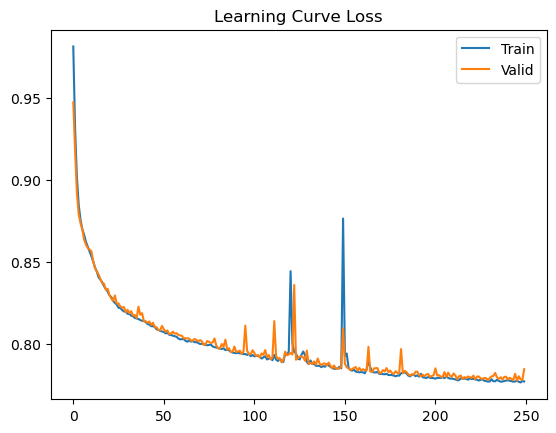

In [39]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()

## Conclusion
This model should converge to loss around 0.78. 